In [7]:
import os
import asyncio
from dotenv import load_dotenv
from openai import AsyncOpenAI
import aiohttp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from typing import List, Dict


In [17]:
load_dotenv(override=True)
client = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))

HEADERS = {"User-Agent": "Mozilla/5.0"}
BING_NEWS_URL = "https://www.bing.com/news/search?q={query}"


In [19]:
import openai

def check_api_key(api_key):
    try:
        openai.api_key = api_key
        openai.models.list()
        print("✅ API key is valid!")
        return True
    except Exception as e:
        print("❌ Invalid API Key:", e)
        return False

# Usage
if not check_api_key(api_key):
    raise ValueError("❌ Please check your OpenAI API key.")


❌ Invalid API Key: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-.... You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


ValueError: ❌ Please check your OpenAI API key.

In [23]:
async def fetch_html(session, url):
    async with session.get(url, headers=HEADERS) as response:
        return await response.text()

async def scrape_bing_news(session, keyword: str, max_results: int = 10):
    query = keyword.replace(" ", "+")
    url = BING_NEWS_URL.format(query=query)
    html = await fetch_html(session, url)
    soup = BeautifulSoup(html, "html.parser")

    # Updated selectors based on actual Bing News structure
    cards = soup.find_all("a", class_="title")  # Headline links
    snippets = soup.find_all("div", class_="snippet")

    results = []
    for i in range(min(max_results, len(cards))):
        title_tag = cards[i]
        snippet_tag = snippets[i] if i < len(snippets) else None
        results.append({
            "title": title_tag.get_text(strip=True),
            "snippet": snippet_tag.get_text(strip=True) if snippet_tag else "No Snippet",
            "link": title_tag.get("href")
        })

    return results


async def summarize_with_openai(articles: List[Dict]) -> str:
    text_block = "\n\n".join([f"Title: {a['title']}\nSnippet: {a['snippet']}" for a in articles])
    messages = [
        {"role": "system", "content": "Summarize the following news articles."},
        {"role": "user", "content": text_block}
    ]
    response = await client.chat.completions.create(
        model="gpt-4",
        messages=messages
    )
    return response.choices[0].message.content

def visualize_articles(articles: List[Dict], keyword: str):
    titles = [f"{i+1}" for i in range(len(articles))]
    lengths = [len(article['title']) for article in articles]
    
    plt.figure(figsize=(10, 5))
    plt.bar(titles, lengths, color='skyblue')
    plt.xlabel('Articles')
    plt.ylabel('Title Length')
    plt.title(f'Article Title Lengths for \"{keyword}\"')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    image_path = f"{keyword}_chart.png"
    plt.savefig(image_path)
    img = Image.open(image_path)
    display(img)
    return image_path


In [24]:
class DataScraperAgent:
    async def scrape_and_visualize(self, keyword: str) -> str:
        async with aiohttp.ClientSession() as session:
            articles = await scrape_bing_news(session, keyword)
            if not articles:
                return "No articles found."
            summary = await summarize_with_openai(articles)
            visualize_articles(articles, keyword)
            return f"### Summary of Articles for '{keyword}':\n\n{summary}"


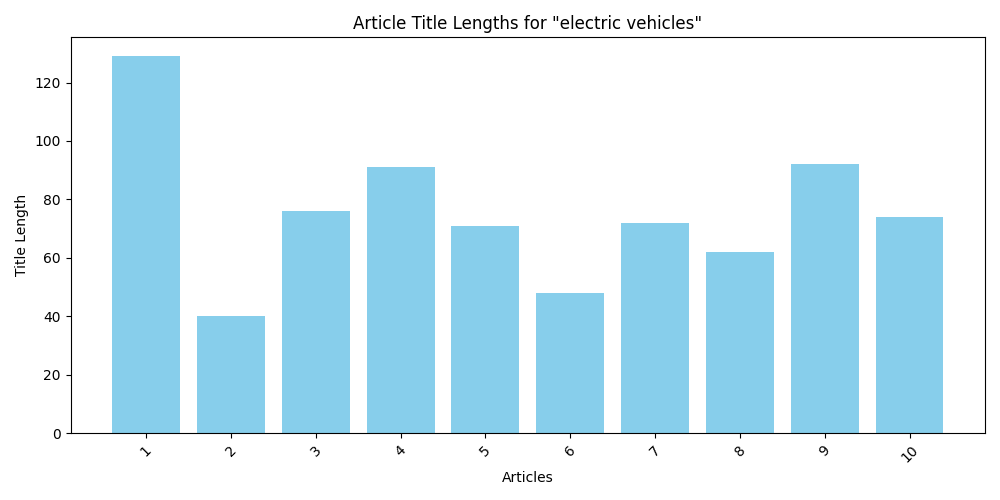

### Summary of Articles for 'electric vehicles':

1. Chetu Foundation has donated seven electric meal delivery vehicles to Akshaya Patra, enabling the charity to feed 18,000 schoolchildren daily in India.
2. The Chandigarh Renewable Energy and Science and Technology Promotion Society launched a new portal for electric vehicles.
3. MG Motor India reports that over 70% of its current revenue comes from electric vehicles, reflecting a 158% year-on-year growth in sales.
4. BMW is celebrating its award-winning vehicles and investing in sustainable futures with the introduction of new electric models.
5. Before the prevalence of electric vehicles, some creative hobbyists were making their own conversions.
6. Openreach, a subsidiary of BT Group, has expanded its fleet to include 5,000 electric vehicles and plans to add 2,000 more.
7. The Indian government questions SIAM about the lack of progress in the vehicle scrapping initiative.
8. The Federal government plans to offer 116,000 electric bi

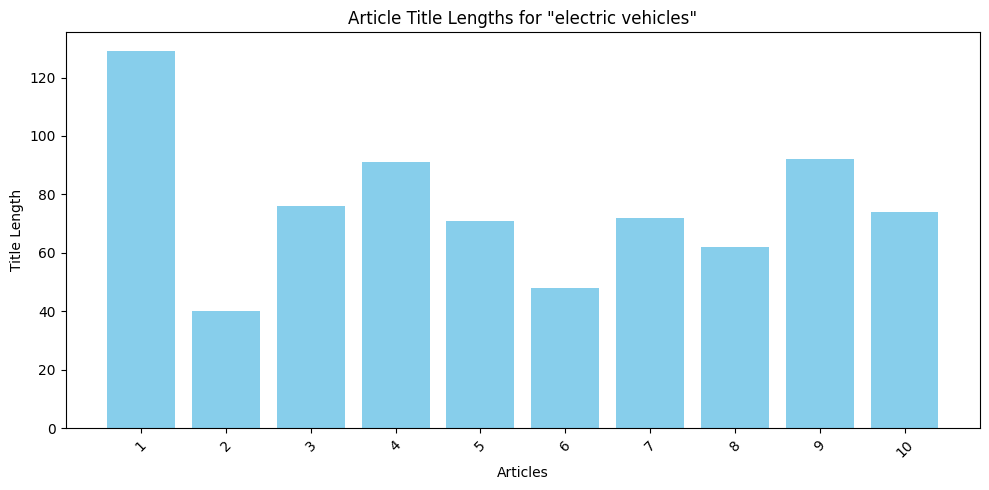

In [25]:
agent = DataScraperAgent()
async def run_agent():
    keyword = "electric vehicles"
    result = await agent.scrape_and_visualize(keyword)
    print(result)

await run_agent()
